# Investigation of performance of net mechanism on a two dimensional toy data set

In [2]:
import second_moment_experiments_main as experiment
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
from exputils import extract_data, initialise_netmech_containers, initialise_adassp_reg_containers, initialise_netmech_reg_containers 
from baselines import Regression, DPRegression
import numpy as np

In [ ]:
# Load data
exp_name = 'exp_2_lattices_density_eps_01'
with open ('D:/Thesis/Experiments/exp_2/' + exp_name, "rb") as container:
    results = pickle.load(container)
exp_name = 'exp_2_lattices_density_eps_1'
with open ('D:/Thesis/Experiments/exp_2/' + exp_name, "rb") as container:
    results_eps_1 = pickle.load(container)
exp_name = 'exp_2_lattices_density_eps_5'
with open ('D:/Thesis/Experiments/exp_2/' + exp_name, "rb") as container:
    results_eps_5 = pickle.load(container)
exp_name = 'exp_2_lattices_density_eps_10'
with open ('D:/Thesis/Experiments/exp_2/' + exp_name, "rb") as container:
    results_eps_10 = pickle.load(container)

## Feature lattice discretisation

$\textbf{Setup}$: Initially, set the targets and features lattice densities to $num\_points\_targets = 4$ and $num\_points\_features = 4$ up to a value of $12$. Then increment them, simultaneously, in steps of $1$. Repeat the experiment for $\varepsilon \in \{0.1, 1, 5, 10\}$. Compare the RMSE of the regression perfromed on the net mechansim synthetic output with the RMSE of the ADASSP algorithm and look at the sample utilities...

In [3]:
# Default parameters list
dimensionality = 2
num_records = 40
test_frac = 0.5
batch_size = 100
directory = 'D:/Thesis/Experiments/exp_2/'
parallel = False
save_data = False
partition_method = 'fast_2'
workers = -1
num_samples = 25
sample_parallel = False 
load_data = False
seed = 23

In [4]:
num_points_max = 20
num_points_min = 4
num_points_features_vec = range(num_points_min, num_points_max + 1)
num_points_targets_vec = range(num_points_min, num_points_max + 1)

### $\varepsilon = 0.1$ case

In [10]:
results = []
epsilon = 0.1
for num_points_features, num_points_targets in zip(num_points_features_vec, num_points_targets_vec):
    print("DEBUG: Num points features", num_points_features)
    print("DEBUG: Num points targets", num_points_targets)
    results.append(experiment.second_order_moment_experiment(dimensionality = dimensionality, num_records = num_records, test_frac = test_frac, batch_size = batch_size,directory = directory, parallel = parallel, save_data = save_data,\
                                                             partition_method = partition_method, workers = workers, num_samples = num_samples,\
                                                             sample_parallel = sample_parallel, load_data = load_data, num_points_targets = num_points_targets,\
                                                             num_points_features = num_points_features, epsilon = epsilon, seed = seed))

DEBUG: Num points features 4
DEBUG: Num points targets 4
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 1
Generating batch 0
Partition function is 64.4028581789233
Max scaled utility is -0.013675755577507408
Generation time 0.0019936561584472656
Sampling time 0.0009965896606445312
Overall max utility -0.027351511155014815
Elapsed time without parallelisation is 0.006980180740356445
DEBUG: Num points features 5
DEBUG: Num points targets 5
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 1
Generating batch 0
Partition function is 1278.6343819472354
Max scaled utility is -0.020620200021951876
Generation time 0.001995086669921875
Sampling time 0.0019936561584472656
Overall max utility -0.04124040004390375
Elapsed time withou

Partition function is 12303860.965344913
Max scaled utility is -0.006491082225057548
Generation time 4.7458815574646
Sampling time 0.3016631603240967
Overall max utility -0.012982164450115095
Elapsed time without parallelisation is 5.047544717788696


In [11]:
# Save the results for latter access
exp_name = 'exp_2_features_eps_01'
with open (directory + exp_name, "wb") as container:
    pickle.dump(results, container)

In [12]:
# Extract data from the results structure 
avg_2_norms, double_std_2_norms, avg_f_norms, double_std_f_norms, max_utilities, max_sampled_utilities, avg_samples_utility,\
double_std_utility, avg_samples_score, double_std_score, synthetic_datasets_vec, test_set, private_data = extract_data(results) 

In [13]:
# Fit ADASSP to the private dataset
epsilon = 0.1
adassp_regressor = DPRegression()
adassp_reg_coef = adassp_regressor.get_parameters(private_data.features, private_data.targets, num_samples, epsilon)
predictive_err_adassp = Regression().calculate_predictive_error(private_data.test_data, adassp_reg_coef)
min_predictive_err_adassp = np.min(predictive_err_adassp)
mean_predictive_err_adassp = np.mean(predictive_err_adassp)
double_std_predictive_err_adassp = 2*np.std(predictive_err_adassp)
print ("Min predictive error adassp", min_predictive_err_adassp)
print ("Mean predictive error adassp", mean_predictive_err_adassp)
print ("Twice the std of predictive err adassp", double_std_predictive_err_adassp)

Min predictive error adassp 0.04146445130318529
Mean predictive error adassp 0.3177099951581301
Twice the std of predictive err adassp 0.5273382251758172


In [25]:
# Regress on the private data for each parameter setting and calculate RMSE statistics
net_mech_reg_coefs = []
predictive_errs_netmech = []
min_predictive_errs_netmech = []
mean_predictive_errs_netmech = []
double_std_predictive_errs_netmech = []
for synthetic_datasets in synthetic_datasets_vec:
    netmech_regressor = Regression()
    net_mech_reg_coef = netmech_regressor.fit_data(synthetic_datasets)
    net_mech_reg_coefs.append(net_mech_reg_coef)
    predictive_err_netmech = netmech_regressor.calculate_predictive_error(private_data.test_data, net_mech_reg_coef)
    predictive_errs_netmech.append(predictive_err_netmech)
    min_predictive_errs_netmech.append(np.min(predictive_err_netmech))
    mean_predictive_errs_netmech.append(np.mean(predictive_err_netmech))
    double_std_predictive_errs_netmech.append(2*np.std(predictive_err_netmech))
print("Overall minimum predictive error for netmechanism (eps = 0.1) is {}, obtained for lattice density = {}."\
      .format(str(np.min(np.array(min_predictive_errs_netmech))),\
              str(list(num_points_features_vec)[np.argmin(np.array(min_predictive_errs_netmech))])))
print("Minimum average predictive error for netmechanism (eps = 0.1) is {}, obtained for lattice density = {}."\
      .format(str(np.min(np.array(mean_predictive_errs_netmech))),\
              str(list(num_points_features_vec)[np.argmin(np.array(mean_predictive_errs_netmech))])))

Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Overall minimum predictive error for netmechanism (eps = 0.1) is 0.028926369209683403, obtained for lattice density = 19.
Minimum average predictive error for netmechanism (eps = 0.1) is 0.4207955076706867, obtained for lattice density = 5.


C:\Users\alexc\OneDrive\Documents\GitHub\Thesis\baselines.py:121: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  parameters[index] = np.linalg.lstsq(Sigma_tensor[index,:,:], correlations[index])[0]


In [26]:
# A look at regression coefficients
# print(net_mech_reg_params)
# print

## $\varepsilon = 1$ case

In [27]:
results_eps_1 = []
epsilon = 1
for num_points_features, num_points_targets in zip(num_points_features_vec, num_points_targets_vec):
    print(num_points_features)
    print(num_points_targets)
    results_eps_1.append(experiment.second_order_moment_experiment(dimensionality = dimensionality, num_records = num_records, test_frac = test_frac, batch_size = batch_size,\
                                               directory = directory, parallel = parallel, save_data = save_data, partition_method = partition_method,\
                                               workers = workers, num_samples = num_samples, sample_parallel = sample_parallel, load_data = load_data,\
                                               num_points_targets = num_points_targets, num_points_features = num_points_features, epsilon = epsilon,\
                                               seed = seed))

4
4
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 1
Generating batch 0
Partition function is 25.843045891341852
Max scaled utility is -0.1367575557750741
Generation time 0.003004789352416992
Sampling time 0.0019826889038085938
Overall max utility -0.02735151115501482
Elapsed time without parallelisation is 0.007979631423950195
5
5
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 1
Generating batch 0
Partition function is 293.5100365808609
Max scaled utility is -0.20620200021951876
Generation time 0.001994609832763672
Sampling time 0.0019943714141845703
Overall max utility -0.04124040004390375
Elapsed time without parallelisation is 0.0059833526611328125
6
6
Initialising synthetic feature space lattice
Synthetic feature 

In [28]:
# Save the results for latter access
exp_name = 'exp_2_features_eps_1'
with open (directory + exp_name, "wb") as container:
    pickle.dump(results_eps_1, container)

In [29]:
# Extract data from the results structure 
avg_2_norms_eps_1, double_std_2_norms_eps_1, avg_f_norms_eps_1, double_std_f_norms_eps_1, max_utilities_eps_1, \
max_sampled_utilities_eps_1, avg_samples_utility_eps_1, double_std_utility_eps_1, avg_samples_score_eps_1, \
double_std_score_eps_1, synthetic_datasets_vec_eps_1, test_set_eps_1, private_data_eps_1 = extract_data(results_eps_1) 

In [30]:
# Fit ADASSP to the private dataset
epsilon = 1
adassp_regressor = DPRegression()
adassp_reg_coef_1 = adassp_regressor.get_parameters(private_data_eps_1.features, private_data_eps_1.targets, num_samples, epsilon)
predictive_err_adassp_eps_1 = Regression().calculate_predictive_error(private_data_eps_1.test_data, adassp_reg_coef_1)
min_predictive_err_adassp_eps_1 = np.min(predictive_err_adassp_eps_1)
mean_predictive_err_adassp_eps_1 = np.mean(predictive_err_adassp_eps_1)
double_std_predictive_err_adassp_eps_1 = 2*np.std(predictive_err_adassp_eps_1)
print ("Min predictive error adassp, eps=1", min_predictive_err_adassp_eps_1)
print ("Mean predictive error adassp, eps=1", mean_predictive_err_adassp_eps_1)
print ("Twice the std of predictive err adassp, eps=1", double_std_predictive_err_adassp_eps_1)

Min predictive error adassp, eps=1 0.037812781581986823
Mean predictive error adassp, eps=1 0.431556791730517
Twice the std of predictive err adassp, eps=1 1.7151257776130495


In [31]:
# Regress on the private data for each parameter setting and calculate RMSE statistics
net_mech_reg_coefs_eps_1 = []
predictive_errs_netmech_eps_1 = []
min_predictive_errs_netmech_eps_1 = []
mean_predictive_errs_netmech_eps_1 = []
double_std_predictive_errs_netmech_eps_1 = []
for synthetic_datasets in synthetic_datasets_vec_eps_1:
    netmech_regressor = Regression()
    net_mech_reg_coef_eps_1 = netmech_regressor.fit_data(synthetic_datasets)
    net_mech_reg_coefs_eps_1.append(net_mech_reg_coef_eps_1)
    predictive_err_netmech_eps_1 = netmech_regressor.calculate_predictive_error(private_data_eps_1.test_data, net_mech_reg_coef_eps_1)
    predictive_errs_netmech_eps_1.append(predictive_err_netmech_eps_1)
    min_predictive_errs_netmech_eps_1.append(np.min(predictive_err_netmech_eps_1))
    mean_predictive_errs_netmech_eps_1.append(np.mean(predictive_err_netmech_eps_1))
    double_std_predictive_errs_netmech_eps_1.append(2*np.std(predictive_err_netmech_eps_1))
print("Overall minimum predictive error for netmechanism (eps = 1) is {}, obtained for n_t = {}."\
      .format(str(np.min(np.array(min_predictive_errs_netmech_eps_1))),\
              str(list(num_points_features_vec)[np.argmin(np.array(min_predictive_errs_netmech_eps_1))])))
print("Minimum average predictive error for netmechanism (eps = 1) is {}, obtained for n_t = {}."\
      .format(str(np.min(np.array(mean_predictive_errs_netmech_eps_1))),\
              str(list(num_points_features_vec)[np.argmin(np.array(mean_predictive_errs_netmech_eps_1))])))

Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Overall minimum predictive error for netmechanism (eps = 1) is 0.034723155232674156, obtained for n_t = 10.
Minimum average predictive error for netmechanism (eps = 1) is 0.3851413216499136, obtained for n_t = 5.


C:\Users\alexc\OneDrive\Documents\GitHub\Thesis\baselines.py:121: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  parameters[index] = np.linalg.lstsq(Sigma_tensor[index,:,:], correlations[index])[0]


## $\varepsilon = 5$ case

In [32]:
results_eps_5 = []
epsilon = 5
for num_points_features, num_points_targets in zip(num_points_features_vec, num_points_targets_vec):
    results_eps_5.append(experiment.second_order_moment_experiment(dimensionality = dimensionality, num_records = num_records, test_frac = test_frac, batch_size = batch_size,\
                                               directory = directory, parallel = parallel, save_data = save_data, partition_method = partition_method,\
                                               workers = workers, num_samples = num_samples, sample_parallel = sample_parallel, load_data = load_data,\
                                               num_points_targets = num_points_targets, num_points_features = num_points_features, epsilon = epsilon,\
                                               seed = seed))

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 1
Generating batch 0
Partition function is 2.0678306293591144
Max scaled utility is -0.6837877788753703
Generation time 0.002992868423461914
Sampling time 0.0009949207305908203
Overall max utility -0.027351511155014815
Elapsed time without parallelisation is 0.0069806575775146484
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 1
Generating batch 0
Partition function is 9.890828878411348
Max scaled utility is -1.0310100010975938
Generation time 0.001996278762817383
Sampling time 0.001993417739868164
Overall max utility -0.04124040004390375
Elapsed tim

In [33]:
# Save the results for latter access
exp_name = 'exp_2_features_eps_5'
with open (directory + exp_name, "wb") as container:
    pickle.dump(results_eps_5, container)

In [34]:
# Extract data from the results structure 
avg_2_norms_eps_5, double_std_2_norms_eps_5, avg_f_norms_eps_5, double_std_f_norms_eps_5, max_utilities_eps_5, max_sampled_utilities_eps_5, avg_samples_utility_eps_5, double_std_utility_eps_5, \
    avg_samples_score_eps_5, double_std_score_eps_5, synthetic_datasets_vec_eps_5, test_set_eps_5, private_data_eps_5 = extract_data(results_eps_5)

In [35]:
# Fit ADASSP to the private dataset
epsilon = 5 
adassp_regressor = DPRegression()
adassp_reg_coef_5 = adassp_regressor.get_parameters(private_data_eps_5.features, private_data_eps_5.targets, num_samples, epsilon)
predictive_err_adassp_eps_5 = Regression().calculate_predictive_error(private_data_eps_5.test_data, adassp_reg_coef_5)
min_predictive_err_adassp_eps_5 = np.min(predictive_err_adassp_eps_5)
mean_predictive_err_adassp_eps_5 = np.mean(predictive_err_adassp_eps_5)
double_std_predictive_err_adassp_eps_5 = 2*np.std(predictive_err_adassp_eps_5)
print ("Min predictive error adassp", min_predictive_err_adassp_eps_5)
print ("Mean predictive error adassp", mean_predictive_err_adassp_eps_5)
print ("Twice the std of predictive err adassp", double_std_predictive_err_adassp_eps_5)

Min predictive error adassp 0.02723301461081399
Mean predictive error adassp 0.218371543626001
Twice the std of predictive err adassp 0.17760520347229442


In [38]:
net_mech_reg_coefs_eps_5 = []
predictive_errs_netmech_eps_5 = []
min_predictive_errs_netmech_eps_5 = []
mean_predictive_errs_netmech_eps_5 = []
double_std_predictive_errs_netmech_eps_5 = []
for synthetic_datasets in synthetic_datasets_vec_eps_5:
    netmech_regressor = Regression()
    net_mech_reg_coef_eps_5 = netmech_regressor.fit_data(synthetic_datasets)
    net_mech_reg_coefs_eps_5.append(net_mech_reg_coef_eps_5)
    predictive_err_netmech_eps_5 = netmech_regressor.calculate_predictive_error(private_data_eps_5.test_data, net_mech_reg_coef_eps_5)
    predictive_errs_netmech_eps_5.append(predictive_err_netmech_eps_5)
    min_predictive_errs_netmech_eps_5.append(np.min(predictive_err_netmech_eps_5))
    mean_predictive_errs_netmech_eps_5.append(np.mean(predictive_err_netmech_eps_5))
    double_std_predictive_errs_netmech_eps_5.append(2*np.std(predictive_err_netmech_eps_5))
print("Overall minimum predictive error for netmechanism (eps = 5) is {}, obtained for lattice density {}."\
      .format(str(np.min(np.array(min_predictive_errs_netmech_eps_5))),\
              str(list(num_points_features_vec)[np.argmin(np.array(min_predictive_errs_netmech_eps_5))])))
print("Minimum average predictive error for netmechanism (eps = 5) is {}, obtained for lattice density {}."\
      .format(str(np.min(np.array(mean_predictive_errs_netmech_eps_5))),\
              str(list(num_points_features_vec)[np.argmin(np.array(mean_predictive_errs_netmech_eps_5))])))

Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Overall minimum predictive error for netmechanism (eps = 5) is 0.03562937639946974, obtained for lattice density 7.
Minimum average predictive error for netmechanism (eps = 5) is 0.22452607794809856, obtained for lattice density 4.


C:\Users\alexc\OneDrive\Documents\GitHub\Thesis\baselines.py:121: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  parameters[index] = np.linalg.lstsq(Sigma_tensor[index,:,:], correlations[index])[0]


## $\varepsilon = 10$ case

In [42]:
results_eps_10 = []
epsilon = 10
for num_points_features, num_points_targets in zip(num_points_features_vec, num_points_targets_vec):
    results_eps_10.append(experiment.second_order_moment_experiment(dimensionality = dimensionality, num_records = num_records, test_frac = test_frac, batch_size = batch_size,\
                                               directory = directory, parallel = parallel, save_data = save_data, partition_method = partition_method,\
                                               workers = workers, num_samples = num_samples, sample_parallel = sample_parallel, load_data = load_data,\
                                               num_points_targets = num_points_targets, num_points_features = num_points_features, epsilon = epsilon,\
                                               seed = seed))

Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 1
Generating batch 0
Partition function is 0.5612117768460543
Max scaled utility is -1.3675755577507407
Generation time 0.0019969940185546875
Sampling time 0.001994609832763672
Overall max utility -0.027351511155014815
Elapsed time without parallelisation is 0.006981372833251953
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 1
Generating batch 0
Partition function is 0.9469883269664153
Max scaled utility is -2.0620200021951876
Generation time 0.001994609832763672
Sampling time 0.000997304916381836
Overall max utility -0.04124040004390375
Elapsed time without parallelisation is 0.006011009216308594
Initialising synthetic feature space lattice
Synthetic feature space initial

In [43]:
# Save the results for latter access
exp_name = 'exp_1_features_eps_10'
with open (directory + exp_name, "wb") as container:
    pickle.dump(results_eps_10, container)

In [44]:
# Extract data from the results structure 
avg_2_norms_eps_10, double_std_2_norms_eps_10, avg_f_norms_eps_10, double_std_f_norms_eps_10, max_utilities_eps_10,max_sampled_utilities_eps_10, avg_samples_utility_eps_10, double_std_utility_eps_10, \
    avg_samples_score_eps_10, double_std_score_eps_10, synthetic_datasets_vec_eps_10, test_set_eps_10, private_data_eps_10 = extract_data(results_eps_10)  

In [45]:
# Fit ADASSP to the private dataset
epsilon = 10
adassp_regressor = DPRegression()
adassp_reg_coef_10 = adassp_regressor.get_parameters(private_data_eps_10.features, private_data_eps_10.targets, num_samples, epsilon)
predictive_err_adassp_eps_10 = Regression().calculate_predictive_error(private_data_eps_10.test_data, adassp_reg_coef_10)
min_predictive_err_adassp_eps_10 = np.min(predictive_err_adassp_eps_10)
mean_predictive_err_adassp_eps_10 = np.mean(predictive_err_adassp_eps_10)
double_std_predictive_err_adassp_eps_10 = 2*np.std(predictive_err_adassp_eps_10)
print ("Min predictive error adassp", min_predictive_err_adassp_eps_10)
print ("Mean predictive error adassp", mean_predictive_err_adassp_eps_10)
print ("Twice the std of predictive err adassp", double_std_predictive_err_adassp_eps_10)

Min predictive error adassp 0.020252205033086633
Mean predictive error adassp 0.18301459498295325
Twice the std of predictive err adassp 0.15505836426454134


In [46]:
net_mech_reg_coefs_eps_10 = []
predictive_errs_netmech_eps_10 = []
min_predictive_errs_netmech_eps_10 = []
mean_predictive_errs_netmech_eps_10 = []
double_std_predictive_errs_netmech_eps_10 = []
for synthetic_datasets in synthetic_datasets_vec_eps_10:
    netmech_regressor = Regression()
    net_mech_reg_coef_eps_10 = netmech_regressor.fit_data(synthetic_datasets)
    net_mech_reg_coefs_eps_10.append(net_mech_reg_coef_eps_5)
    predictive_err_netmech_eps_10 = netmech_regressor.calculate_predictive_error(private_data_eps_10.test_data, net_mech_reg_coef_eps_10)
    predictive_errs_netmech_eps_10.append(predictive_err_netmech_eps_10)
    min_predictive_errs_netmech_eps_10.append(np.min(predictive_err_netmech_eps_10))
    mean_predictive_errs_netmech_eps_10.append(np.mean(predictive_err_netmech_eps_10))
    double_std_predictive_errs_netmech_eps_10.append(2*np.std(predictive_err_netmech_eps_10))
print("Overall minimum predictive error for netmechanism (eps = 10) is {}, obtained for n_t = {}."\
      .format(str(np.min(np.array(min_predictive_errs_netmech_eps_10))),\
              str(list(num_points_features_vec)[np.argmin(np.array(min_predictive_errs_netmech_eps_10))])))
print("Minimum average predictive error for netmechanism (eps = 10) is {}, obtained for n_t = {}."\
      .format(str(np.min(np.array(mean_predictive_errs_netmech_eps_10))),\
              str(list(num_points_features_vec)[np.argmin(np.array(mean_predictive_errs_netmech_eps_10))])))

Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Overall minimum predictive error for netmechanism (eps = 10) is 0.032980955546125706, obtained for n_t = 19.
Minimum average predictive error for netmechanism (eps = 10) is 0.055969286432246544, obtained for n_t = 4.


C:\Users\alexc\OneDrive\Documents\GitHub\Thesis\baselines.py:121: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  parameters[index] = np.linalg.lstsq(Sigma_tensor[index,:,:], correlations[index])[0]


## Plots

In [47]:
xcoordinate = list(num_points_features_vec)

#### Average samples utility

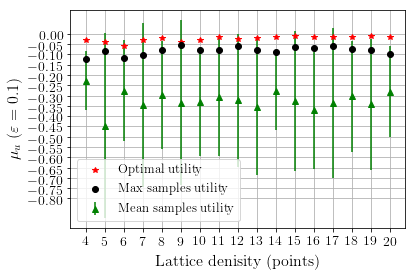

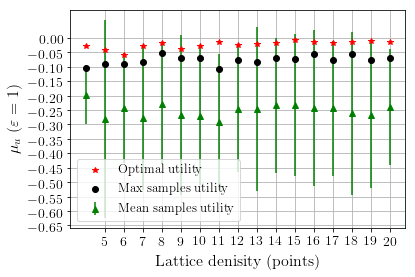

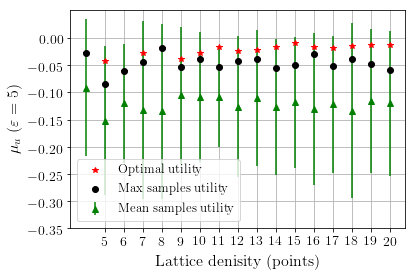

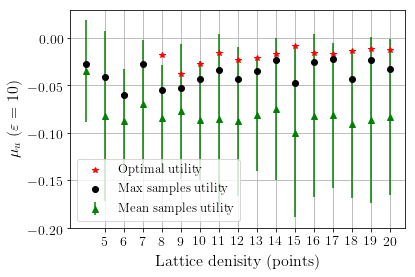

In [48]:
plt.errorbar(xcoordinate, avg_samples_utility, yerr = double_std_utility, fmt = 'g^', label = 'Mean samples utility')
plt.plot(xcoordinate, max_utilities, 'r*', label = 'Optimal utility')
plt.plot(xcoordinate, max_sampled_utilities, 'ko', label = 'Max samples utility')
plt.xticks(xcoordinate)
plt.yticks(np.arange(-0.8, 0.02, step = 0.05))
plt.xlabel('Lattice denisity (points)', fontsize = 16)
plt.ylabel(r'$\mu_u$ ($\varepsilon = 0.1$)', fontsize = 16)
plt.legend(fontsize = 13)
plt.grid(True)
plt.show()

plt.errorbar(xcoordinate, avg_samples_utility_eps_1, yerr = double_std_utility_eps_1, fmt = 'g^', label = 'Mean samples utility')
plt.plot(xcoordinate, max_utilities, 'r*', label = 'Optimal utility')
plt.plot(xcoordinate, max_sampled_utilities_eps_1, 'ko', label = 'Max samples utility')
plt.xticks(range(5,21))
plt.yticks(np.arange(-0.65, 0.02, step = 0.05))
plt.xlabel('Lattice denisity (points)', fontsize = 16)
plt.ylabel(r'$\mu_u$ ($\varepsilon = 1$)', fontsize = 16)
plt.grid(True)
plt.legend(fontsize = 13)
plt.show()

plt.errorbar(xcoordinate, avg_samples_utility_eps_5, yerr = double_std_utility_eps_5, fmt = 'g^', label = 'Mean samples utility')
plt.plot(xcoordinate, max_utilities, 'r*', label = 'Optimal utility')
plt.plot(xcoordinate, max_sampled_utilities_eps_5, 'ko', label = 'Max samples utility')
plt.xticks(range(5,21))
plt.yticks(np.arange(-0.35, 0.02, step = 0.05))
plt.xlabel('Lattice denisity (points)', fontsize = 16)
plt.ylabel(r'$\mu_u$ ($\varepsilon = 5$)', fontsize = 16)
plt.grid(True)
plt.legend(fontsize = 13)
plt.show()

plt.errorbar(xcoordinate, avg_samples_utility_eps_10, yerr = double_std_utility_eps_10, fmt = 'g^', label = 'Mean samples utility')
plt.plot(xcoordinate, max_utilities, 'r*', label = 'Optimal utility')
plt.plot(xcoordinate, max_sampled_utilities_eps_10, 'ko', label = 'Max samples utility')
plt.xticks(range(5,21))
plt.yticks(np.arange(-0.2, 0.02, step = 0.05))
plt.xlabel('Lattice denisity (points)', fontsize = 16)
plt.ylabel(r'$\mu_u$ ($\varepsilon = 10$)', fontsize = 16)
plt.grid(True)
plt.legend(fontsize = 13)
plt.show()

#### RMSE plots

The variance/mean of ADASSP blows up when $\varepsilon$ is around $1$. For example, when setting $\varepsilon = 0.8$, the standard deviation of the ADASSP solution is $23.60$ while the mean is $5.07$ while the minimum RMSE error is $0.03$. This is caused by one sample, for which the RMSE is $120.707$. For that example, the regression coefficients are $-392.68$ and $330.50$. The same sample causes the large standard deviation for the $\varepsilon = 1$ case (plotted). 

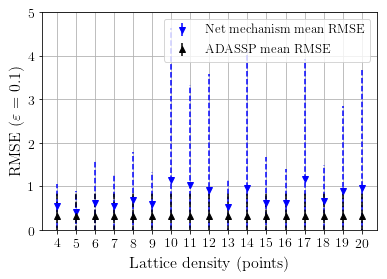

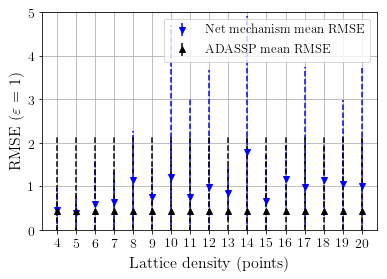

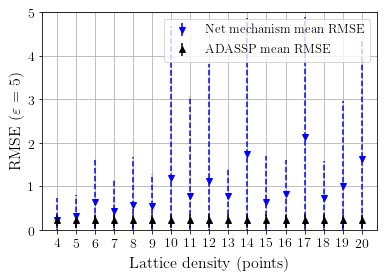

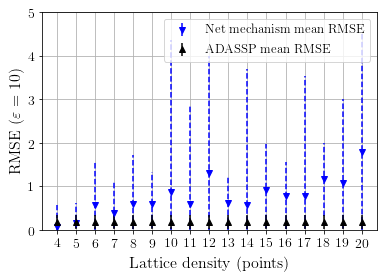

In [49]:
eb = plt.errorbar(xcoordinate, mean_predictive_errs_netmech, yerr = double_std_predictive_errs_netmech, fmt = 'bv', label = 'Net mechanism mean RMSE')
eb[-1][0].set_linestyle('--')
plt.xticks(xcoordinate)
# plt.axhline(y = mean_predictive_err_adassp, color = 'r', linestyle='--', label = 'ADASSP mean RMSE')
eb1 = plt.errorbar(xcoordinate, [mean_predictive_err_adassp]*len(xcoordinate), yerr = [double_std_predictive_err_adassp]*len(xcoordinate), fmt = 'k^', label = 'ADASSP mean RMSE')
eb1[-1][0].set_linestyle('--')
#plt.yticks(np.arange(0, 0.8, step = 0.05))
plt.ylim([0, 5])
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'RMSE ($\varepsilon = 0.1$)', fontsize = 16)
plt.grid(True)
plt.legend(fontsize=13)
plt.show()

eb =plt.errorbar(xcoordinate, mean_predictive_errs_netmech_eps_1, yerr = double_std_predictive_errs_netmech, fmt = 'bv', label = 'Net mechanism mean RMSE')
eb[-1][0].set_linestyle('--')
plt.xticks(xcoordinate)
#plt.axhline(y = mean_predictive_err_adassp_eps_1, color = 'r', linestyle='--', label = 'ADASSP mean RMSE')
eb = plt.errorbar(xcoordinate, [mean_predictive_err_adassp_eps_1]*len(xcoordinate), yerr = [double_std_predictive_err_adassp_eps_1]*len(xcoordinate), fmt = 'k^', label = 'ADASSP mean RMSE')
eb[-1][0].set_linestyle('--')
#plt.yticks(np.arange(0, 0.8, step = 0.05))
plt.ylim([0, 5])
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'RMSE ($\varepsilon = 1$)', fontsize = 16)
plt.grid(True)
plt.legend(fontsize = 13)
plt.show()

eb = plt.errorbar(xcoordinate, mean_predictive_errs_netmech_eps_5, yerr = double_std_predictive_errs_netmech, fmt = 'bv', label = 'Net mechanism mean RMSE')
eb[-1][0].set_linestyle('--')
plt.xticks(xcoordinate)
#plt.axhline(y = mean_predictive_err_adassp_eps_5, color = 'r', linestyle='--', label = 'ADASSP mean RMSE')
eb = plt.errorbar(xcoordinate, [mean_predictive_err_adassp_eps_5]*len(xcoordinate), yerr = [double_std_predictive_err_adassp_eps_5]*len(xcoordinate), fmt = 'k^', label = 'ADASSP mean RMSE')
eb[-1][0].set_linestyle('--')
#plt.yticks(np.arange(0, 0.8, step = 0.05))
plt.ylim([0, 5])
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'RMSE ($\varepsilon = 5$)', fontsize = 16)
plt.grid(True)
plt.legend(fontsize=13)
plt.show()

eb = plt.errorbar(xcoordinate, mean_predictive_errs_netmech_eps_10, yerr = double_std_predictive_errs_netmech, fmt = 'bv', label = 'Net mechanism mean RMSE')
eb[-1][0].set_linestyle('--')
plt.xticks(xcoordinate)
#plt.axhline(y = mean_predictive_err_adassp_eps_10, color = 'r', linestyle='--', label = 'ADASSP mean RMSE')
eb = plt.errorbar(xcoordinate, [mean_predictive_err_adassp_eps_10]*len(xcoordinate), yerr = [double_std_predictive_err_adassp_eps_10]*len(xcoordinate), fmt = 'k^', label = 'ADASSP mean RMSE')
#plt.yticks(np.arange(0, 0.8, step = 0.05))
plt.ylim([0, 5])
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'RMSE ($\varepsilon = 10$)', fontsize = 16)
plt.grid(True)
plt.legend(fontsize=13)
plt.show()

## Plots

#### Correlations difference norm (!!!)

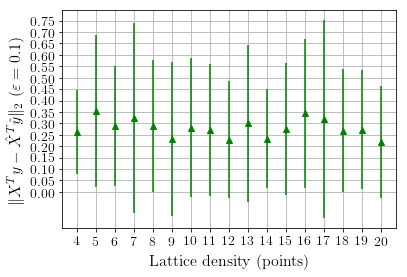

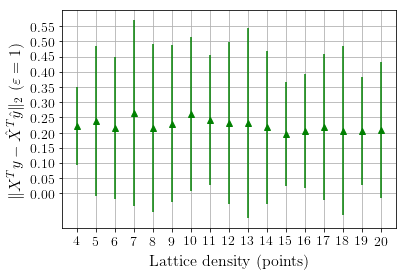

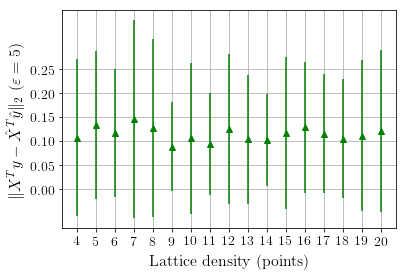

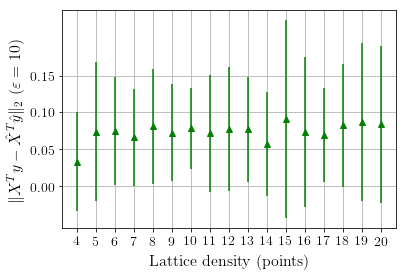

In [50]:
plt.errorbar(xcoordinate, avg_2_norms, yerr = double_std_2_norms, fmt = 'g^')
plt.xticks(xcoordinate)
plt.yticks(np.arange(0, 0.8, step = 0.05))
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'$\|X^Ty - \hat{X}^T\hat{y}\|_2$ ($\varepsilon = 0.1$)', fontsize = 16)
plt.grid(True)
plt.show()

plt.errorbar(xcoordinate, avg_2_norms_eps_1, yerr = double_std_2_norms_eps_1, fmt = 'g^')
plt.xticks(xcoordinate)
plt.yticks(np.arange(0, 0.6, step = 0.05))
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'$\|X^Ty - \hat{X}^T\hat{y}\|_2$ ($\varepsilon = 1$)', fontsize = 16)
plt.grid(True)
plt.show()

plt.errorbar(xcoordinate, avg_2_norms_eps_5, yerr = double_std_2_norms_eps_5, fmt = 'g^')
plt.xticks(xcoordinate)
plt.yticks(np.arange(0, 0.3, step = 0.05))
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'$\|X^Ty - \hat{X}^T\hat{y}\|_2$ ($\varepsilon = 5$)', fontsize = 16)
plt.grid(True)
plt.show()

plt.errorbar(xcoordinate, avg_2_norms_eps_10, yerr = double_std_2_norms_eps_10, fmt = 'g^')
plt.xticks(xcoordinate)
plt.yticks(np.arange(0, 0.2, step = 0.05))
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'$\|X^Ty - \hat{X}^T\hat{y}\|_2$ ($\varepsilon = 10$)', fontsize = 16)
plt.grid(True)
plt.show()

#### Frobenius norm

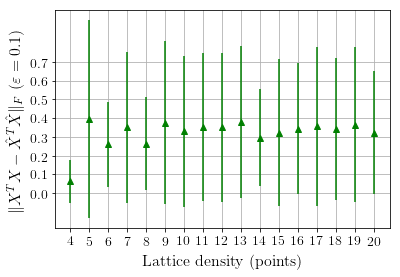

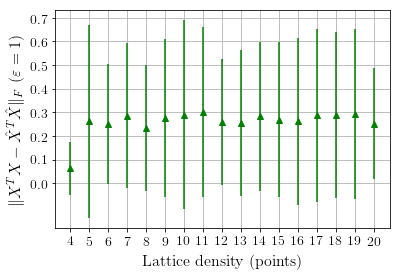

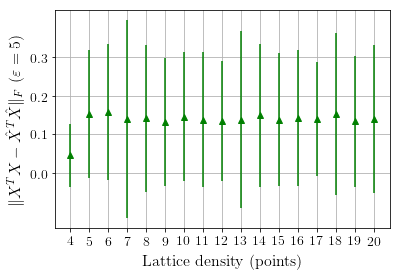

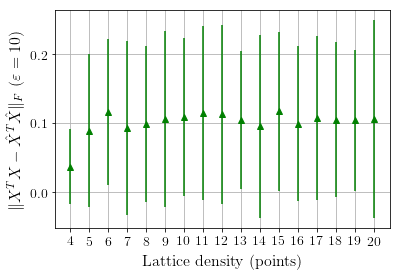

In [51]:
plt.errorbar(xcoordinate, avg_f_norms, yerr = double_std_f_norms, fmt = 'g^')
plt.xticks(xcoordinate)
plt.yticks(np.arange(0, 0.8, step = 0.1))
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'$\|X^TX - \hat{X}^T \hat{X} \|_F$ ($\varepsilon = 0.1$)', fontsize = 16)
plt.grid(True)
plt.show()

plt.errorbar(xcoordinate, avg_f_norms_eps_1, yerr = double_std_f_norms_eps_1, fmt = 'g^')
plt.xticks(xcoordinate)
plt.yticks(np.arange(0, 0.8, step = 0.1))
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'$\|X^TX - \hat{X}^T \hat{X} \|_F$ ($\varepsilon = 1$)', fontsize = 16)
plt.grid(True)
plt.show()

plt.errorbar(xcoordinate, avg_f_norms_eps_5, yerr = double_std_f_norms_eps_5, fmt = 'g^')
plt.xticks(xcoordinate)
plt.yticks(np.arange(0, 0.4, step = 0.1))
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'$\|X^TX - \hat{X}^T \hat{X} \|_F$ ($\varepsilon = 5$)', fontsize = 16)
plt.grid(True)
plt.show()

plt.errorbar(xcoordinate, avg_f_norms_eps_10, yerr = double_std_f_norms_eps_10, fmt = 'g^')
plt.xticks(xcoordinate)
plt.yticks(np.arange(0, 0.3, step = 0.1))
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel(r'$\|X^TX - \hat{X}^T \hat{X} \|_F$ ($\varepsilon = 10$)', fontsize = 16)
plt.grid(True)
plt.show()

#### Optimal utility

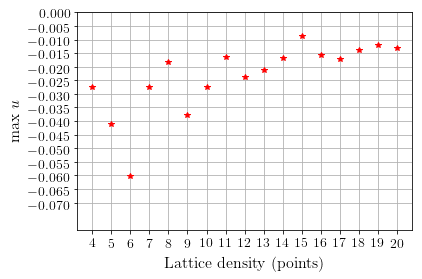

In [52]:
plt.plot(xcoordinate, max_utilities, 'r*', label = 'Optimal utility')
plt.xticks(xcoordinate)
plt.yticks(np.arange(-0.07, 0.0, step = 0.005))
plt.xlabel('Lattice density (points)', fontsize = 16)
plt.ylabel('max $u$', fontsize = 16)
plt.ylim([-0.08,0])
plt.grid(True)
# plt.legend(fontsize = 13)
plt.show()

# Improving experimental set up

In [5]:
# Load data
exp_name = 'exp_2_lattice_denisty'
with open ('D:/Thesis/Experiments/exp_2/' + exp_name, "rb") as container:
    results = pickle.load(container)

In [7]:
epsilon_vec = [0.1, 1.0, 5.0, 10.0]

In [5]:
# Collect results
results = {key: [] for key in epsilon_vec}
for epsilon in epsilon_vec:
    for num_points_features, num_points_targets in zip(num_points_features_vec, num_points_targets_vec):
        results[epsilon].append(experiment.second_order_moment_experiment(dimensionality = dimensionality, num_records = num_records, test_frac = test_frac, batch_size = batch_size,directory = directory, parallel = parallel, save_data = save_data,\
                                                                 partition_method = partition_method, workers = workers, num_samples = num_samples,\
                                                                 sample_parallel = sample_parallel, load_data = load_data, num_points_targets = num_points_targets,\
                                                                 num_points_features = num_points_features, epsilon = epsilon, seed = seed))

Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 1
Generating batch 0
Partition function is 64.4028581789233
Max scaled utility is -0.013675755577507408
Generation time 0.003987550735473633
Sampling time 0.000997304916381836
Overall max utility -0.027351511155014815
Elapsed time without parallelisation is 0.007976770401000977
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 1
Generating batch 0
Partition function is 1278.6343819472354
Max scaled utility is -0.020620200021951876
Generation time 0.002991914749145508
Sampling time 0.0009975433349609375
Overall max utility -0.04124040004390375
Elapsed time without parallelisation is 0.0069806575775146484
Initialising synthetic feature space lattice
Synthetic feature space init

Partition function is 80764.06559107277
Max scaled utility is -0.0812020002195192
Generation time 0.1001746654510498
Sampling time 0.031243562698364258
Overall max utility -0.01624040004390384
Elapsed time without parallelisation is 0.13141822814941406
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 39
Generating batch 0
Partition function is 129059.02454814943
Max scaled utility is -0.11839208286414687
Generation time 0.1181023120880127
Sampling time 0.07444071769714355
Overall max utility -0.023678416572829375
Elapsed time without parallelisation is 0.19453787803649902
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 64
Generating batch 0
Partition function is 231886.53471840528
Max scaled utility is -0.1068468025522069

Partition function is 8908.076431378082
Max scaled utility is -0.5342340127610347
Generation time 0.2158958911895752
Sampling time 0.0677797794342041
Overall max utility -0.021369360510441388
Elapsed time without parallelisation is 0.2866671085357666
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 77
Generating batch 0
Partition function is 14440.149036740431
Max scaled utility is -0.4208029005058778
Generation time 0.31833863258361816
Sampling time 0.1100318431854248
Overall max utility -0.016832116020235113
Elapsed time without parallelisation is 0.43036699295043945
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 111
Generating batch 0
Partition function is 22627.909870600513
Max scaled utility is -0.21565933496089143


Partition function is 1512.5663541487315
Max scaled utility is -0.8416058010117556
Generation time 0.4142274856567383
Sampling time 0.06289410591125488
Overall max utility -0.016832116020235113
Elapsed time without parallelisation is 0.47712159156799316
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 111
Generating batch 0
Partition function is 2369.9897686878003
Max scaled utility is -0.43131866992178286
Generation time 0.6315972805023193
Sampling time 0.09136366844177246
Overall max utility -0.008626373398435657
Elapsed time without parallelisation is 0.7249550819396973
Initialising synthetic feature space lattice
Synthetic feature space initialised
Initialising synthethic target space lattice
Synthethic target space initialised
Number of batches is 148
Generating batch 0
Partition function is 3591.499921502602
Max scaled utility is -0.790690247744290

In [6]:
# Save the results for latter access
exp_name = 'exp_2_lattice_denisty'
with open (directory + exp_name, "wb") as container:
    pickle.dump(results, container)

In [8]:
# Experimental data containers
avg_2_norms, double_std_2_norms, avg_f_norms, double_std_f_norms, max_utilities, max_sampled_utilities, avg_samples_utility,\
double_std_utility, avg_samples_score, double_std_score, synthetic_datasets_vec, test_set, private_data = initialise_netmech_containers(epsilon_vec)

In [9]:
# Extract data from the results data structure 
for key in results:
    avg_2_norms[key], double_std_2_norms[key], avg_f_norms[key], double_std_f_norms[key], max_utilities[key], max_sampled_utilities[key],\
    avg_samples_utility[key], double_std_utility[key], avg_samples_score[key], double_std_score[key], synthetic_datasets_vec[key],\
    test_set[key], private_data[key] = extract_data(results[key]) 

In [10]:
# Initialise containers for the regression on the synthetic data sets released with netmechanism
net_mech_reg_coefs, predictive_errs_netmech, min_predictive_errs_netmech, mean_predictive_errs_netmech,\
double_std_predictive_errs_netmech = initialise_netmech_reg_containers(epsilon_vec)

# Initialise containers for the regression on the synthetic data sets with parameters released by ADASSP
adassp_reg_coef, predictive_err_adassp, min_predictive_err_adassp, mean_predictive_err_adassp, double_std_predictive_err_adassp = initialise_adassp_reg_containers(epsilon_vec)

In [11]:
# Fit ADASSP to the private dataset and calculate the predictive error
for epsilon in epsilon_vec:
    adassp_regressor = DPRegression()
    adassp_reg_coef[epsilon] = adassp_regressor.get_parameters(private_data[epsilon].features, private_data[epsilon].targets,\
                                                           num_samples, epsilon)
    predictive_err_adassp[epsilon] = Regression().calculate_predictive_error(private_data[epsilon].test_data, adassp_reg_coef[epsilon])
    min_predictive_err_adassp[epsilon] = np.min(predictive_err_adassp[epsilon])
    mean_predictive_err_adassp[epsilon] = np.mean(predictive_err_adassp[epsilon])
    double_std_predictive_err_adassp[epsilon] = 2*np.std(predictive_err_adassp[epsilon])
    print ("Min predictive error adassp for eps " + str(epsilon) , min_predictive_err_adassp[epsilon])
    print ("Mean predictive error adassp " + str(epsilon), mean_predictive_err_adassp[epsilon])
    print ("Twice the std of predictive err adassp " + str(epsilon), double_std_predictive_err_adassp[epsilon])

Min predictive error adassp for eps 0.1 0.04146445130318529
Mean predictive error adassp 0.1 0.3177099951581301
Twice the std of predictive err adassp 0.1 0.5273382251758172
Min predictive error adassp for eps 1.0 0.037812781581986823
Mean predictive error adassp 1.0 0.431556791730517
Twice the std of predictive err adassp 1.0 1.7151257776130495
Min predictive error adassp for eps 5.0 0.02723301461081399
Mean predictive error adassp 5.0 0.218371543626001
Twice the std of predictive err adassp 5.0 0.17760520347229442
Min predictive error adassp for eps 10.0 0.020252205033086633
Mean predictive error adassp 10.0 0.18301459498295325
Twice the std of predictive err adassp 10.0 0.15505836426454134


In [12]:
# Perform regression on the datasets released with the net mechanism and calculate predictive error statistics
for epsilon in epsilon_vec:
    for synthetic_datasets in synthetic_datasets_vec[epsilon]:
        netmech_regressor = Regression()
        net_mech_reg_coef = netmech_regressor.fit_data(synthetic_datasets)
        net_mech_reg_coefs[epsilon].append(net_mech_reg_coef)
        predictive_err_netmech = netmech_regressor.calculate_predictive_error(private_data[epsilon].test_data, net_mech_reg_coef)
        predictive_errs_netmech[epsilon].append(predictive_err_netmech)
        min_predictive_errs_netmech[epsilon].append(np.min(predictive_err_netmech))
        mean_predictive_errs_netmech[epsilon].append(np.mean(predictive_err_netmech))
        double_std_predictive_errs_netmech[epsilon].append(2*np.std(predictive_err_netmech))
    print("Overall minimum predictive error for netmechanism with epsilon " + str(epsilon) + " is {}, obtained for n_t = {}."\
          .format(str(np.min(np.array(min_predictive_errs_netmech[epsilon]))),\
                  str(list(num_points_features_vec)[np.argmin(np.array(min_predictive_errs_netmech[epsilon]))])))
    print("Minimum average predictive error for netmechanism with epsilon " + str(epsilon) + " is {}, obtained for n_t = {}."\
          .format(str(np.min(np.array(mean_predictive_errs_netmech[epsilon]))),\
                  str(list(num_points_features_vec)[np.argmin(np.array(mean_predictive_errs_netmech[epsilon]))])))

Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Overall minimum predictive error for netmechanism with epsilon 0.1 is 0.028926369209683403, obtained for n_t = 19.
Minimum average predictive error for netmechanism with epsilon 0.1 is 0.4207955076706867, obtained for n_t = 5.
Warning, there were singular sythethic matrices
Warning, there were singular sythethic matrices
Warni

C:\Users\alexc\OneDrive\Documents\GitHub\Thesis\baselines.py:121: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  parameters[index] = np.linalg.lstsq(Sigma_tensor[index,:,:], correlations[index])[0]
